In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import datetime 
import glob
import xarray as xr
from setdir import *
from plotglider import *
from parseglider import *


# Updated purpose of process_data.ipynb

Now, loads the *.nc file (e.g. unit_409_20220124.nc, and assigns up/down index, also creates a gridded file)


In [40]:
# Slocum gliders: A dictionary with the key as the serial number ('unit_398') 
# and then the plain text name, "Churchill"
glider_names = {
    'unit_409': 'Grease',
    'unit_398': 'Churchill',
}
unit_list = [(k) for k in glider_names.keys()]

# Time format string (should be the same as in 01-load_raw_data.ipynb)
time_strf = '%Y%m%d'

In [51]:
# Load the latest files for each glider in unit_list
idx_d={} ; idx_c={};

# Name for a new data array to index profiles
idxname = 'profile_index'
# Name for data array already created for pressure in dbar
presname = 'pressure_dbar'

for uname in unit_list:
    fname = uname+'_2022*nc'
    
    # Extract a list with the names of existing raw data files
    existing_files = glob.glob(cat_raw_path(fname))

    # Check whether there are any files
    if len(existing_files) > 0:
        # Extract the end date from the filename
        existing_files = sorted(existing_files)
        latest_file = existing_files[-1]
        
        # Open the dataset
        data_ds = xr.open_dataset(latest_file)
        
        # Assign indices to count the number of profiles
        # where 20.0 means the twentieth dive (downward profile)
        # and 20.5 is the twentieth climb (upward profile)
        data_ds, idx_d[uname], idx_c[uname] = dive_index(data_ds, 
                                                         presname,
                                                         idxname)
         
        if 0:
            # Check whether a gridded file has already been created
            # Not yet implemented
            proc_files = glob.glob(cat_interim_path(fname))
            if not len(proc_files) > 0:
                print('No processed files for that glider')
        
        # Remove data ararys that have no non-nan values
        for varname in data_ds.keys():
            data_val = data_ds[varname].values
            num = np.count_nonzero(~np.isnan(data_val))
            if num==0:
                data_ds = data_ds.drop(varname)

                
        # Evaluate this string to save both outputs
        # But could instead use a dictionary..
        execstr = uname+'=data_ds.copy()'
        exec(execstr)
        print('Running '+execstr)
        
        # Save the result to processed data
        fname1 = os.path.basename(latest_file)
        data_ds.to_netcdf(cat_proc_path(fname1))
        

7. Changing iclimb, idx was 363, is now 364
54. Changing idive, idx was 3277 is now  3276
68. Changing iclimb, idx was 5842, is now 5843
77. Changing iclimb, idx was 8434, is now 8435
222. Changing iclimb, idx was 39856, is now 39857
229. Changing iclimb, idx was 42374, is now 42375
236. Changing iclimb, idx was 44910, is now 44911
240. Changing iclimb, idx was 46221, is now 46222
248. Changing iclimb, idx was 48832, is now 48833
263. Changing iclimb, idx was 53668, is now 53669
Running unit_409=data_ds.copy()
1. Changing idive, idx was 111 is now  110
16. Changing iclimb, idx was 927, is now 928
21. Changing idive, idx was 1345 is now  1344
105. Changing idive, idx was 26666 is now  26665
123. Changing iclimb, idx was 32035, is now 32036
144. Changing iclimb, idx was 38467, is now 38468
Running unit_398=data_ds.copy()


# Load profile indices (dive/climb)


In [43]:
# Wouldn't plot for me because I hadn't loaded both of them at the same time.
idx_c['unit_409'] = np.where( unit_409[idxname] % 1 == .5)[0] # climb indices
idx_d['unit_409'] = np.where( unit_409[idxname] % 1 == 0)[0] # dive indices

idx_c['unit_398'] = np.where( unit_398[idxname] % 1 == .5)[0] # climb indices
idx_d['unit_398'] = np.where( unit_398[idxname] % 1 == 0)[0] # dive indices

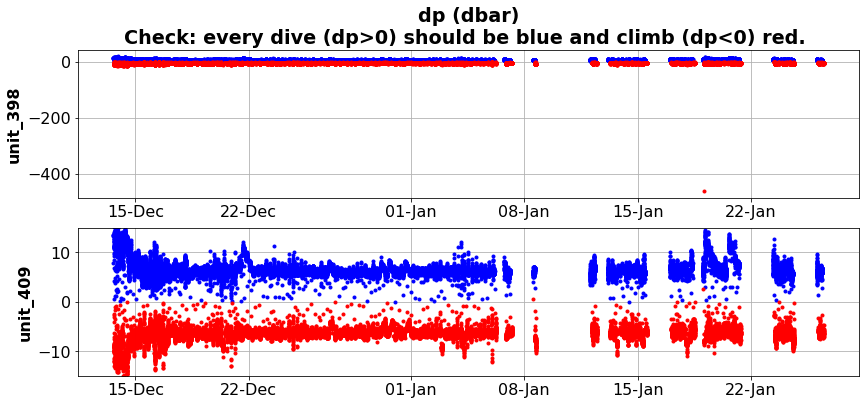

In [44]:
plot_dp(unit_398,'unit_398',unit_409,'unit_409',idx_d,idx_c)

# Grid data onto a regular 10-dbar pressure grid & save

This creates a regular 10-dbar grid between 0 and 1000 dbar, 
and uses a 'mean' to average any two datapoints within the same bin.

There are some gaps (e.g. when the decimated data transmitted weren't
frequent enough to have a datapoint in every bin.  This might be worth
interpolating over (linear interpolation in pressure) for better figures.

Note this is a quick and dirty process, and so is for visualisation
purposes only!


In [63]:
# Create a regularly gridded product with ~10m depth bins.
# Takes a little while 
dp=10

grid409 = bin_dp(unit_409, 'unit_409', dp)
# Next line may not be necessary:
# edited parseglider.py to pass atributes along.
grid409 = grid409.assign_attrs(unit_409.attrs) 
grid409.to_netcdf(cat_proc_path(grid409.attrs['Serial number']+'_bin10m.nc'), mode='w')

In [60]:
#grid398 = bin_dp(unit_398, 'unit_398', dp)
grid398 = grid398.assign_attrs(unit_398.attrs)
grid398.to_netcdf(cat_proc_path(grid398.attrs['Serial number']+'_bin10m.nc'), mode='w')

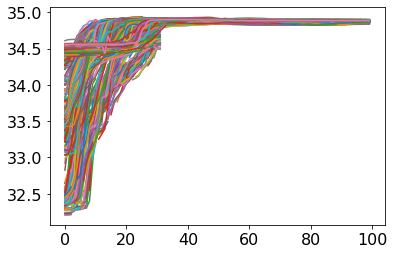

In [68]:
plt.plot(grid409.derived_salinity)
plt.show()